In [11]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import sparse
from tqdm import tqdm
import os

import torch

pd.options.display.width = 180
pd.options.display.max_colwidth = 120

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # RTX 2080 Ti

data_dir = Path('/workspace/Kaggle/AI4Code')


In [63]:
available_gpus = [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())]
available_gpus

['GeForce RTX 2080 Ti']

In [13]:
batch_size = 32
num_workers = 8
code_max_len = 23
md_max_len = 64
total_max_len = 512

In [14]:
def read_notebook(path):
    return (pd.read_json(path,
                         dtype={
                             'cell_type': 'category',
                             'source': 'str'
                         }).assign(id=path.stem).rename_axis('cell_id'))

In [8]:
paths_train = list((data_dir / 'train').glob('*.json'))
notebooks_train = [
    read_notebook(path) for path in tqdm(paths_train, desc='Train NBs')
]
df = (pd.concat(notebooks_train).set_index(
    'id', append=True).swaplevel().sort_index(level='id',
                                              sort_remaining=False))

df_orders = pd.read_csv(
    data_dir / 'train_orders.csv',
    index_col='id',
    squeeze=True,
).str.split()  # Split the string representation of cell_ids into a list

Train NBs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 139256/139256 [07:12<00:00, 321.90it/s]


In [25]:
df

,id,cell_id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
0,00001756c60be8,1862f0a6,code,# This Python 3 environment comes with many helpful analytics libraries installed\n# It is defined by the kaggle/pyt...,0,945aea18,NaN,0.0
1,00001756c60be8,2a9e43d6,code,"import numpy as np\nimport pandas as pd\nimport random\n\nfrom sklearn.model_selection import train_test_split, cros...",2,945aea18,NaN,0.034483
2,00001756c60be8,038b763d,code,import warnings\nwarnings.filterwarnings('ignore'),4,945aea18,NaN,0.068966
3,00001756c60be8,2eefe0ef,code,matplotlib.rcParams.update({'font.size': 14}),6,945aea18,NaN,0.103448
4,00001756c60be8,0beab1cd,code,"def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):\n print(""Train R2:\...",8,945aea18,NaN,0.137931
...,...,...,...,...,...,...,...,...
6370641,fffe1d764579d5,0d770d6b,markdown,## REMOVING THE OUTLIERS,43,3c40bfa6,NaN,0.597222
6370642,fffe1d764579d5,d45ddc62,markdown,### DIMENSIONALITY CURSE,33,3c40bfa6,NaN,0.458333
6370643,fffe1d764579d5,1a63248d,markdown,# BANGALORE HOUSE PRICE PREDICTION,0,3c40bfa6,NaN,0.0
6370644,fffe1d764579d5,a8ffc8b4,markdown,* We have achieved 75.2% accuracy in predicting the prices of the homes in Banglore using Decision Tree Regressor,69,3c40bfa6,NaN,0.958333


In [49]:
# Get an example notebook
# nb_id = df.index.unique('id')[6]
nb_id = "fffe1d764579d5"
print('Notebook ID:', nb_id)

nb = df[df["id"] == nb_id]
nb = nb.set_index("cell_id")

cell_order = df_orders[nb_id]

print("Ordered notebook:")
nb.loc[cell_order, :].head(50)

Notebook ID: fffe1d764579d5
Ordered notebook:


,id,cell_type,source,rank,ancestor_id,parent_id,pct_rank
cell_id,,,,,,,
1a63248d,fffe1d764579d5,markdown,# BANGALORE HOUSE PRICE PREDICTION,0,3c40bfa6,NaN,0.0
9c3b96a5,fffe1d764579d5,code,"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n for filename in filenames:\n print(os....",1,3c40bfa6,NaN,0.013889
1398a873,fffe1d764579d5,code,import pandas as pd \nimport numpy as np \nimport matplotlib\nfrom matplotlib import pyplot as plt\nimport seaborn a...,2,3c40bfa6,NaN,0.027778
4e2d4c2d,fffe1d764579d5,markdown,## DATA INGESTION,3,3c40bfa6,NaN,0.041667
f71c538e,fffe1d764579d5,code,df = pd.read_csv('/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv'),4,3c40bfa6,NaN,0.055556
8b44a5e8,fffe1d764579d5,code,"df.sample(5,random_state=23)",5,3c40bfa6,NaN,0.069444
385dff7a,fffe1d764579d5,code,df.info(),6,3c40bfa6,NaN,0.083333
b8254ef8,fffe1d764579d5,code,df.shape,7,3c40bfa6,NaN,0.097222
4d0e433e,fffe1d764579d5,markdown,## DATA PREPROCESSING,8,3c40bfa6,NaN,0.111111


In [56]:
tmp = df.copy()
tmp = tmp[tmp["cell_type"] == "markdown"]
tmp = tmp.groupby("id").size().reset_index(name='counts').reset_index(drop=True)
tmp

,id,counts
0,00001756c60be8,28
1,00015c83e2717b,21
2,0001bdd4021779,2
3,0001daf4c2c76d,51
4,0002115f48f982,1
...,...,...
139251,fffc30d5a0bc46,9
139252,fffc3b44869198,1
139253,fffc63ff750064,4
139254,fffcd063cda949,12


In [62]:
tmp["counts"].describe()

count    139256.000000
mean         15.554547
std          17.223756
min           1.000000
25%           5.000000
50%          11.000000
75%          20.000000
max         537.000000
Name: counts, dtype: float64

<AxesSubplot:>

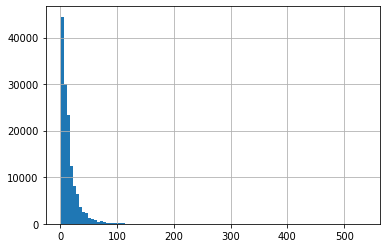

In [59]:
tmp["counts"].hist(bins=100)

In [16]:
def get_ranks(base, derived):
    return [base.index(d) for d in derived]


df_orders_ = df_orders.to_frame().join(
    df.reset_index('cell_id').groupby('id')['cell_id'].apply(list),
    how='right',
)

ranks = {}
for id_, cell_order, cell_id in df_orders_.itertuples():
    ranks[id_] = {'cell_id': cell_id, 'rank': get_ranks(cell_order, cell_id)}
df_ranks = (
    pd.DataFrame
        .from_dict(ranks, orient='index')
        .rename_axis('id')
        .apply(pd.Series.explode)
        .set_index('cell_id', append=True)
)

df_ancestors = pd.read_csv(data_dir / 'train_ancestors.csv', index_col='id')
df = df.reset_index().merge(df_ranks, on=["id", "cell_id"]).merge(df_ancestors, on=["id"])
df["pct_rank"] = df["rank"] / df.groupby("id")["cell_id"].transform("count")

In [66]:
df.groupby("id")["cell_id"].transform("count")

0          58
1          58
2          58
3          58
4          58
           ..
6370641    72
6370642    72
6370643    72
6370644    72
6370645    72
Name: cell_id, Length: 6370646, dtype: int64

In [17]:
paths_test = list((data_dir / 'test').glob('*.json'))
notebooks_test = [
    read_notebook(path) for path in tqdm(paths_test, desc='Test NBs')
]
test_df = (pd.concat(notebooks_test).set_index(
    'id',
    append=True).swaplevel().sort_index(level='id',
                                        sort_remaining=False)).reset_index()
# Dummy rankings
test_df["rank"] = test_df.groupby(["id", "cell_type"]).cumcount()

# Rankings in percentile form
test_df["pred"] = test_df.groupby(["id", "cell_type"])["rank"].rank(pct=True)

Test NBs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 252.33it/s]


In [67]:
test_df

,id,cell_id,cell_type,source,rank,pred
0,0009d135ece78d,ddfd239c,code,"import numpy as np # linear algebra\nimport pandas as pd # data processing,\nimport matplotlib.pyplot as plt\nfrom s...",0,0.142857
1,0009d135ece78d,c6cd22db,code,df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')\ndf,1,0.285714
2,0009d135ece78d,1372ae9b,code,"numerical_data = df.loc[:, ~df.columns.isin(['id', ""diagnosis""])]\n\nlabels = df[""diagnosis""].factorize(['B','M'])[0...",2,0.428571
3,0009d135ece78d,90ed07ab,code,"def comparison_plot_maker(data_1, data_2, name, column_name_1, column_name_2):\n # Scaling Data for testing\n ...",3,0.571429
4,0009d135ece78d,7f388a41,code,"# Ploting data with different columns\n#####################################\ncomparison_plot_maker(numerical_data[""...",4,0.714286
...,...,...,...,...,...,...
84,0010a919d60e4f,d3f5c397,markdown,We have 177 rows with missing `Age` and 687 rows with missing `Cabin`,34,1.000000
85,0028856e09c5b7,012c9d02,code,"sns.set()\nsns.pairplot(data1, 2.5)\nplt.show(); = size",0,0.333333
86,0028856e09c5b7,d22526d1,code,"types----------"")\n# is uniques----------"")\n# plt\nimport mis_val +\n = #https://pandas.pydata.org/pandas...",1,0.666667
87,0028856e09c5b7,3ae7ece3,code,"#correlation avoid map\nf,ax verbose 20), 18))\nsns.heatmap(data1.corr(), the annot=True, ; informations bins=50, '....",2,1.000000


In [68]:
# Additional code cells
def clean_code(cell):
    return str(cell).replace("\\n", "\n")


def sample_cells(cells, n=20):
    cells = [clean_code(cell) for cell in cells]
    if n >= len(cells):
        # Extract first 200 characters from each cell
        return [cell[:200] for cell in cells]
    else:
        results = []
        step = len(cells) / n
        idx = 0
        # Select cell in forward order by steps
        while int(np.round(idx)) < len(cells):
            results.append(cells[int(np.round(idx))])
            idx += step
            
        # Ensure 1st and last cells are selected
        assert cells[0] in results
        if cells[-1] not in results:
            results[-1] = cells[-1]
        return results


def get_features(df):
    features = dict()
    df = df.sort_values("rank").reset_index(drop=True)
    for idx, sub_df in tqdm(df.groupby("id")):
        features[idx] = dict()
        total_md = sub_df[sub_df.cell_type == "markdown"].shape[0]
        code_sub_df = sub_df[sub_df.cell_type == "code"]
        total_code = code_sub_df.shape[0]
        # Select up to 20 cells
        codes = sample_cells(code_sub_df.source.values, 20)
        features[idx]["total_code"] = total_code
        features[idx]["total_md"] = total_md
        features[idx]["codes"] = codes
    return features

In [69]:
test_fts = get_features(test_df)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1045.77it/s]


In [76]:
for idx, sub_df in tqdm(test_df.groupby("id")):
    print(idx)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 9834.24it/s]

0009d135ece78d
0010483c12ba9b
0010a919d60e4f
0028856e09c5b7


In [92]:
from tqdm import tqdm
import sys, os
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch


class MarkdownModel(nn.Module):

    def __init__(self, model_path):
        super(MarkdownModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_path)
        self.top = nn.Linear(769, 1)

    def forward(self, ids, mask, fts):
        x = self.model(ids, mask)[0]
        x = self.top(torch.cat((x[:, 0, :], fts), 1))
        return x


from torch.utils.data import DataLoader, Dataset


class MarkdownDataset(Dataset):

    def __init__(self, df, model_name_or_path, total_max_len, md_max_len, fts):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.md_max_len = md_max_len
        self.total_max_len = total_max_len  # maxlen allowed by model config
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
        self.fts = fts

    def __getitem__(self, index):
        row = self.df.iloc[index]

        inputs = self.tokenizer.encode_plus(row.source,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.md_max_len,
                                            padding="max_length",
                                            return_token_type_ids=True,
                                            truncation=True)
        code_inputs = self.tokenizer.batch_encode_plus(
            [str(x) for x in self.fts[row.id]["codes"]],
            add_special_tokens=True,
            max_length=code_max_len,
            padding="max_length",
            truncation=True)
        n_md = self.fts[row.id]["total_md"]
        n_code = self.fts[row.id]["total_md"]
        if n_md + n_code == 0:
            fts = torch.FloatTensor([0])
        else:
            fts = torch.FloatTensor([n_md / (n_md + n_code)])

        ids = inputs['input_ids']

        print(
            self.tokenizer.convert_tokens_to_string(
                self.tokenizer.convert_ids_to_tokens([ids[0], ids[-1]])))

        for x in code_inputs['input_ids']:

            # Remove tailing special SEP
            ids.extend(x[:-1])
        ids = ids[:self.total_max_len]
        if len(ids) != self.total_max_len:
            ids = ids + [
                self.tokenizer.pad_token_id,
            ] * (self.total_max_len - len(ids))
        ids = torch.LongTensor(ids)

        mask = inputs['attention_mask']
        for x in code_inputs['attention_mask']:
            mask.extend(x[:-1])
        mask = mask[:self.total_max_len]
        if len(mask) != self.total_max_len:
            mask = mask + [
                self.tokenizer.pad_token_id,
            ] * (self.total_max_len - len(mask))
        mask = torch.LongTensor(mask)

        assert len(ids) == self.total_max_len

        return ids, mask, fts, torch.FloatTensor([row.pct_rank])

    def __len__(self):
        return self.df.shape[0]

In [93]:
def read_data(data):
    return tuple(d.cuda() for d in data[:-1]), data[-1].cuda()


def validate(model, val_loader):
    model.eval()

    tbar = tqdm(val_loader, file=sys.stdout)

    preds = []
    labels = []

    with torch.no_grad():
        for idx, data in enumerate(tbar):
            inputs, target = read_data(data)

            pred = model(*inputs)

            preds.append(pred.detach().cpu().numpy().ravel())
            labels.append(target.detach().cpu().numpy().ravel())

    return np.concatenate(labels), np.concatenate(preds)


def predict(model_path, ckpt_path):
    model = MarkdownModel(model_path)
    model = model.cuda()
    model.eval()
    model.load_state_dict(torch.load(ckpt_path))
    test_df["pct_rank"] = 0
    test_ds = MarkdownDataset(
        test_df[test_df["cell_type"] == "markdown"].reset_index(drop=True),
        md_max_len=md_max_len,
        total_max_len=total_max_len,
        model_name_or_path=model_path,
        fts=test_fts)
    test_loader = DataLoader(test_ds,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=num_workers,
                             pin_memory=False,
                             drop_last=False)
    _, y_test = validate(model, test_loader)
    return y_test

In [81]:
# y_test = (y_test_1 + y_test_2)/2
y_test = y_test_2

In [82]:
test_df.loc[test_df["cell_type"] == "markdown", "pred"] = y_test

In [83]:
sub_df = test_df.sort_values("pred").groupby("id")["cell_id"].apply(lambda x: " ".join(x)).reset_index()
sub_df.rename(columns={"cell_id": "cell_order"}, inplace=True)
sub_df.head()

,id,cell_order
0,0009d135ece78d,0a226b6a ddfd239c 8cb8d28a c6cd22db 1372ae9b e25aa9bd 90ed07ab ba55e576 39e937ec f9893819 7f388a41 2843a25a 06dbf8cf
1,0010483c12ba9b,7f270e34 54c7cab3 fe66203e 7844d5f8 5ce8863c 4a0777c4 4703bb6d 4a32c095 865ad516 02a0be6d
2,0010a919d60e4f,23607d04 b7578789 aafc3d23 80e077ec bbff12d4 584f6568 b190ebb4 d3f5c397 ed415c3c 8ce62db4 322850af 5115ebe5 5e8c5e7e...
3,0028856e09c5b7,012c9d02 eb293dfc d22526d1 3ae7ece3


In [13]:
sub_df.to_csv("submission.csv", index=False)